Imports

In [1]:
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap

from imblearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                             make_scorer, recall_score)
from sklearn.model_selection import GridSearchCV, learning_curve

from global_vars import chargement_train_test_data, chargement_df

c:\Users\estel\Documents\Apprentissage\Datascientest\Projet\feb24_bds_accidents\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = chargement_df()
X_train, y_train, X_test, y_test = chargement_train_test_data()

## 6. Modelling

#### SGDClassifier 15 variables 2014-2022

In [ ]:
# Définir les métriques d'évaluation avec le scoring personnalisé
scorer = make_scorer(recall_score, average='macro', labels=[2])

# Définir les hyperparamètres du SGDClassifier
param_grid_sgd = {
    'classifier__alpha': [0.0001, 0.001, 0.01],
    'classifier__loss': ['hinge', 'modified_huber'],
    'classifier__penalty': ['l2', 'l1', 'elasticnet'],
    'classifier__max_iter': [1000, 2000, 3000]
}

# Initialiser le classificateur SGDClassifier
sgd = SGDClassifier()

# Créer le pipeline avec l'undersampling et le classificateur
pipeline = Pipeline([
    ('classifier', sgd)
])

# Initialiser GridSearchCV avec le pipeline et les hyperparamètres
grid_search_sgd15 = GridSearchCV(estimator=pipeline, param_grid=param_grid_sgd, cv=5, scoring=scorer, n_jobs=4)

# Exécuter la recherche sur la grille sur les données d'entraînement
grid_search_sgd15.fit(X_train, y_train)

# Obtenir les meilleurs paramètres
best_params_sgd15 = grid_search_sgd15.best_params_
print("Meilleurs paramètres:", best_params_sgd15)

# Prédire sur les données de test avec le meilleur modèle 
y_pred_sgd15 = grid_search_sgd15.best_estimator_.predict(X_test)

# Évaluer les prédictions sur les données de test
class_report_sgd15 = classification_report(y_test, y_pred_sgd15)
print("Rapport de classification sur les données de test :\n", class_report_sgd15)


Meilleurs paramètres: {'classifier__alpha': 0.0001, 'classifier__loss': 'hinge', 'classifier__max_iter': 1000, 'classifier__penalty': 'elasticnet'}
Rapport de classification sur les données de test :
               precision    recall  f1-score   support

           1       0.55      0.84      0.66      6163
           2       0.47      0.74      0.58      6163
           3       0.37      0.20      0.26      6164
           4       0.50      0.18      0.27      6163

    accuracy                           0.49     24653
   macro avg       0.47      0.49      0.44     24653
weighted avg       0.47      0.49      0.44     24653



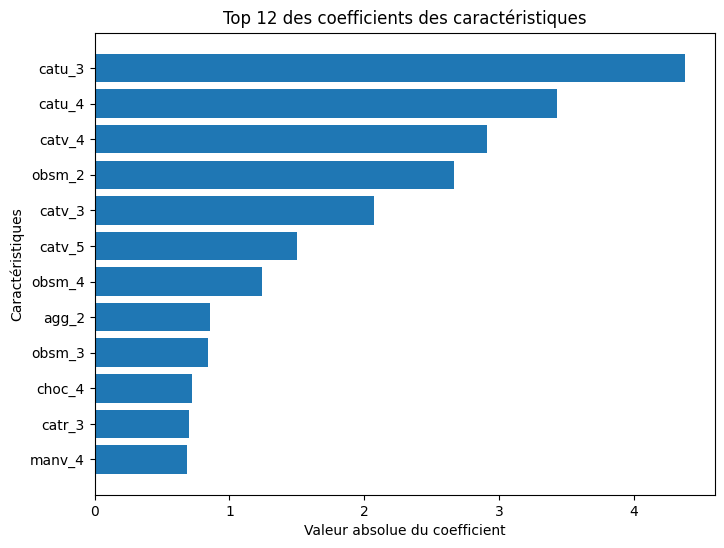

In [ ]:
# Récupérer le meilleur modèle du GridSearchCV
best_model = grid_search_sgd15.best_estimator_['classifier']

# Extraire les coefficients attribués à chaque caractéristique
coefficients = best_model.coef_[0]

# Récupérer les noms des caractéristiques
feature_names = X_train.columns

# Créer un DataFrame des coefficients avec les noms des caractéristiques
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': np.abs(coefficients)})

# Trier le DataFrame par les valeurs absolues des coefficients dans l'ordre décroissant
coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)


# Garder seulement les 10 premières caractéristiques
top_10_features = coefficients_df.head(12)

# Afficher le graphique des coefficients pour les 10 premières caractéristiques
plt.figure(figsize=(8, 6))
plt.barh(top_10_features['Feature'], top_10_features['Coefficient'])
plt.xlabel('Valeur absolue du coefficient')
plt.ylabel('Caractéristiques')
plt.title('Top 12 des coefficients des caractéristiques')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
coefficients_df.head(48)

,Feature,Coefficient
1,catu_3,4.381925
2,catu_4,3.430567
5,catv_4,2.912734
7,obsm_2,2.667366
4,catv_3,2.070444
6,catv_5,1.501109
9,obsm_4,1.245032
21,agg_2,0.855887
8,obsm_3,0.841421
47,choc_4,0.722766


##### Courbes d'apprentissage et de validation

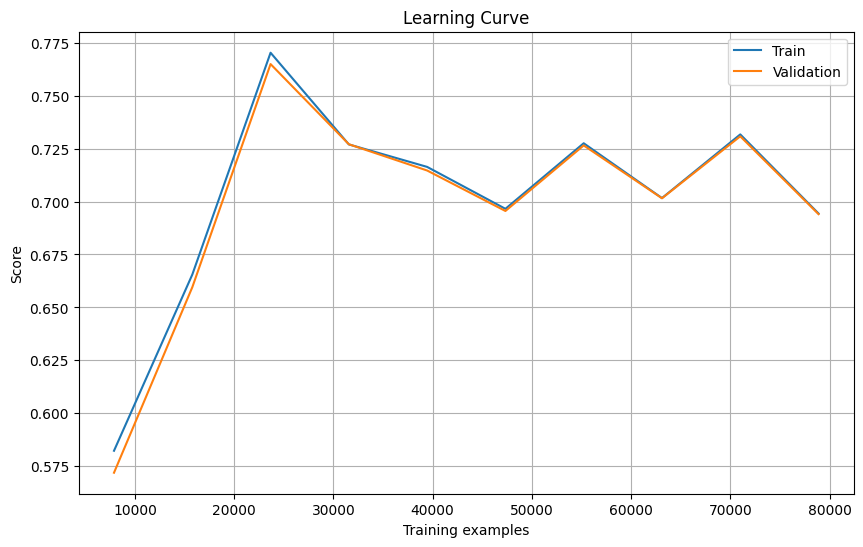

In [ ]:
train_sizes, train_scores, valid_scores = learning_curve(grid_search_sgd15.best_estimator_, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring=scorer, n_jobs=4)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Train')
plt.plot(train_sizes, np.mean(valid_scores, axis=1), label='Validation')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend()
plt.grid()
plt.show()


##### Matrice de confusion

Matrice de confusion :
 [[5163  623  253  124]
 [ 792 4576  569  226]
 [1120 3054 1211  779]
 [2354 1437 1250 1122]]


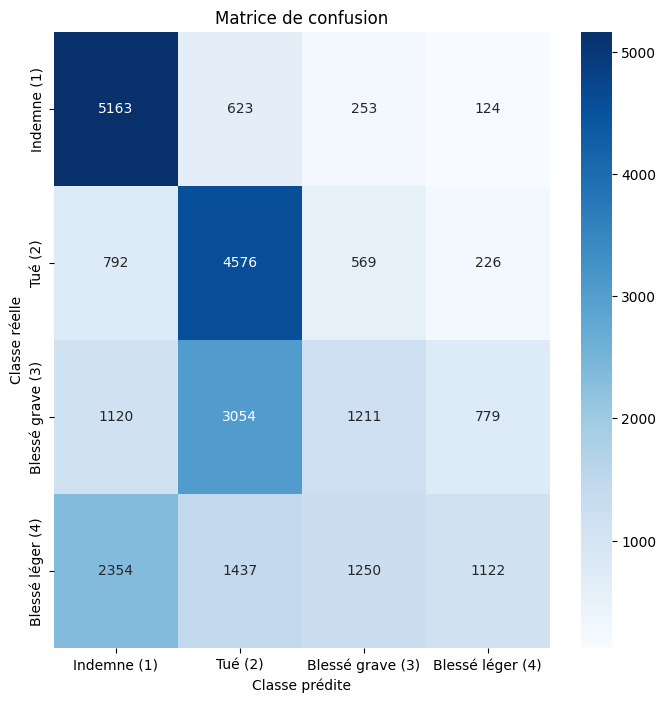

In [ ]:
# 1. Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_sgd15)
print("Matrice de confusion :\n", conf_matrix)


# Définir les étiquettes de classe
class_names = ["Indemne (1)", "Tué (2)", "Blessé grave (3)", "Blessé léger (4)"]


# Créer un heatmap de la matrice de confusion
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Matrice de confusion")
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.show()

In [ ]:
# Définir les métriques d'évaluation avec le scoring personnalisé
scorer = make_scorer(recall_score, average='macro', labels=[2])

# Définir les hyperparamètres du SGDClassifier
param_grid_sgd = {
    'classifier__alpha': [0.0001, 0.001, 0.01],
    'classifier__loss': ['hinge', 'modified_huber'],
    'classifier__penalty': ['l2', 'l1', 'elasticnet'],
    'classifier__max_iter': [1000, 2000, 3000]
}

# Initialiser le classificateur SGDClassifier
sgd = SGDClassifier()

# Créer le pipeline avec l'undersampling et le classificateur
pipeline = Pipeline([
    ('classifier', sgd)
])

# Initialiser GridSearchCV avec le pipeline et les hyperparamètres
grid_search_sgd15bis = GridSearchCV(estimator=pipeline, param_grid=param_grid_sgd, cv=5, scoring=scorer, n_jobs=4)

# Exécuter la recherche sur la grille sur les données d'entraînement
grid_search_sgd15bis.fit(X_train, y_train)

# Obtenir les meilleurs paramètres
best_params_sgd15bis = grid_search_sgd15bis.best_params_
print("Meilleurs paramètres:", best_params_sgd15bis)

# Prédire sur les données de test avec le meilleur modèle
y_pred_sgd15bis = grid_search_sgd15bis.best_estimator_.predict(X_test)

# Évaluer les prédictions sur les données de test
class_report_sgd15bis = classification_report(y_test, y_pred_sgd15bis)
print("Rapport de classification sur les données de test :\n", class_report_sgd15bis)




KeyboardInterrupt: 

#### SGDClassifier à 8 variables 2005-2022

In [ ]:
# Définir les métriques d'évaluation avec le scoring personnalisé
scorer = make_scorer(recall_score, average='macro', labels=[2])

# Définir les hyperparamètres du SGDClassifier
param_grid_sgd = {
    'classifier__alpha': [0.0001, 0.001, 0.01],
    'classifier__loss': ['hinge', 'log', 'modified_huber'],
    'classifier__penalty': ['l2', 'l1', 'elasticnet'],
    'classifier__max_iter': [1000, 2000, 3000]
}

# Initialiser le classificateur SGDClassifier
sgd = SGDClassifier()

# Créer le pipeline avec l'undersampling et le classificateur
pipeline = Pipeline([
    ('classifier', sgd)
])

# Initialiser GridSearchCV avec le pipeline et les hyperparamètres
grid_search8 = GridSearchCV(estimator=pipeline, param_grid=param_grid_sgd, cv=5, scoring=scorer, n_jobs=4)

# Exécuter la recherche sur la grille sur les données d'entraînement
grid_search8.fit(X_train, y_train)

# Obtenir les meilleurs paramètres
best_params8 = grid_search8.best_params_
print("Meilleurs paramètres:", best_params8)

# Prédire sur les données de test avec le meilleur modèle
y_pred = grid_search8.best_estimator_.predict(X_test)

# Évaluer les prédictions sur les données de test
class_report8 = classification_report(y_test, y_pred)
print("Rapport de classification sur les données de test :\n", class_report8)


Meilleurs paramètres: {'classifier__alpha': 0.001, 'classifier__loss': 'hinge', 'classifier__max_iter': 3000, 'classifier__penalty': 'l1'}
Rapport de classification sur les données de test :
               precision    recall  f1-score   support

           1       0.65      0.83      0.73    215596
           2       0.08      0.62      0.14     14118
           3       0.31      0.17      0.22    103938
           4       0.56      0.22      0.31    192809

    accuracy                           0.47    526461
   macro avg       0.40      0.46      0.35    526461
weighted avg       0.53      0.47      0.46    526461



#### RandomForest à 15 variables 2014-2022

In [ ]:
# Définir les métriques d'évaluation avec le scoring personnalisé
scorer = make_scorer(recall_score, average='macro', labels=[2])

# Définir les hyperparamètres du RandomForestClassifier
param_grid_rf = {
    'classifier__n_estimators': [70, 100, 200, 300],
    'classifier__max_depth': [10, 20, 30, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4, 6]
}

# Initialiser le classificateur RandomForestClassifier
rf = RandomForestClassifier()

# Créer le pipeline avec le classificateur
pipeline = Pipeline([
    ('classifier', rf)
])

# Initialiser GridSearchCV avec le pipeline et les hyperparamètres
grid_search_rf15 = GridSearchCV(estimator=pipeline, param_grid=param_grid_rf, cv=5, scoring=scorer, n_jobs=4)

# Exécuter la recherche sur la grille sur les données d'entraînement
grid_search_rf15.fit(X_train, y_train)

# Obtenir les meilleurs paramètres
best_params_rf15 = grid_search_rf15.best_params_
print("Meilleurs paramètres:", best_params_rf15)

# Prédire sur les données de test avec le meilleur modèle
y_pred_rf15 = grid_search_rf15.best_estimator_.predict(X_test)

# Afficher le rapport de classification sur les données de test
class_report15 = classification_report(y_test, y_pred_rf15)
print("Rapport de classification sur les données de test :\n", class_report15)


Meilleurs paramètres: {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 6, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Rapport de classification sur les données de test :
               precision    recall  f1-score   support

           1       0.63      0.76      0.69      6163
           2       0.53      0.66      0.59      6163
           3       0.42      0.28      0.34      6164
           4       0.49      0.43      0.46      6163

    accuracy                           0.53     24653
   macro avg       0.52      0.53      0.52     24653
weighted avg       0.52      0.53      0.52     24653



100%|===================| 98605/98612 [265:00<00:01]         

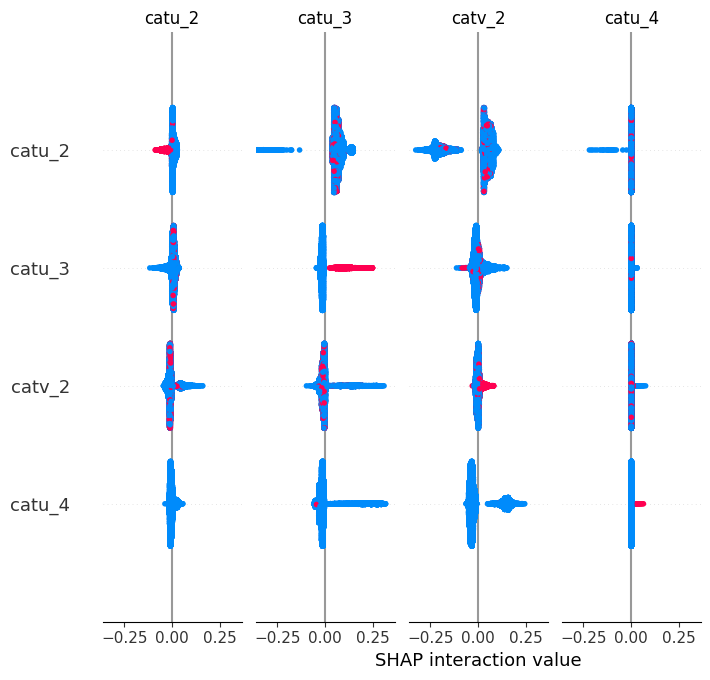

In [ ]:
# Créer un objet explainer SHAP avec le meilleur modèle
explainer = shap.Explainer(grid_search_rf15.best_estimator_.named_steps['classifier'], X_train)

# Calculer les valeurs SHAP pour un échantillon de données
shap_values = explainer.shap_values(X_test)

# Afficher les valeurs SHAP
shap.summary_plot(shap_values, X_test, plot_type="bar")


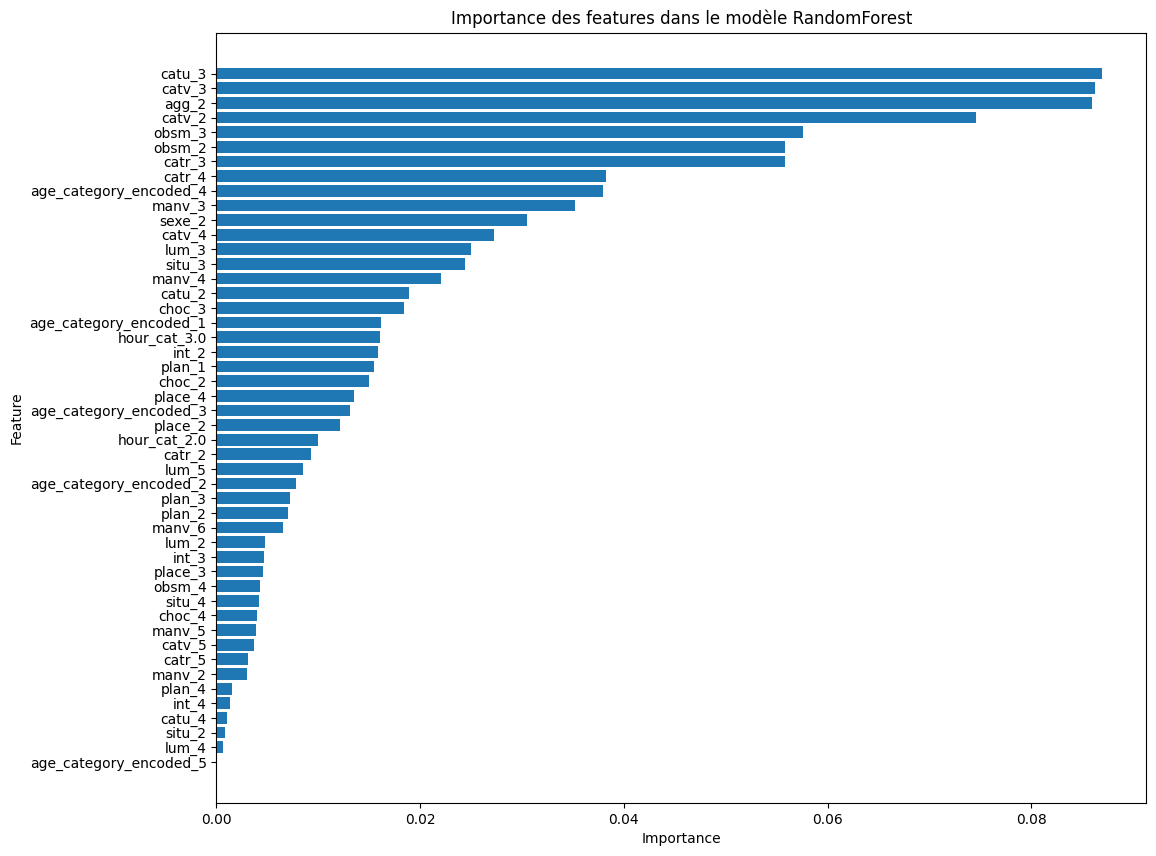

In [ ]:
# Obtenir l'importance des features à partir du meilleur modèle
feature_importance = grid_search_rf15.best_estimator_.named_steps['classifier'].feature_importances_

# Obtenez le nom des features
feature_names = X_train.columns  

# Créer un DataFrame pour une meilleure manipulation
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Trier les features par importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Tracer les features importantes
plt.figure(figsize=(12, 10))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Importance des features dans le modèle RandomForest')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# Filtrer les données pour chaque valeur de sexe
accidents_sexe1 = df[df['sexe'] == 1]
accidents_sexe2 = df[df['sexe'] == 2]

# Compter le nombre total d'accidents pour chaque valeur de sexe
nombre_accidents_sexe1 = len(accidents_sexe1)
nombre_accidents_sexe2 = len(accidents_sexe2)

# Compter le nombre d'accidents où la gravité est égale à 2 pour chaque valeur de sexe
nombre_grav2_sexe1 = len(accidents_sexe1[accidents_sexe1['grav'] == 2])
nombre_grav2_sexe2 = len(accidents_sexe2[accidents_sexe2['grav'] == 2])

# Calculer la proportion d'accidents pour lesquels la gravité est égale à 2 pour chaque valeur de sexe
proportion_grav2_sexe1 = nombre_grav2_sexe1 / nombre_accidents_sexe1
proportion_grav2_sexe2 = nombre_grav2_sexe2 / nombre_accidents_sexe2

print("Proportion d'accidents de gravité 2 pour sexe = 1:", proportion_grav2_sexe1)
print("Proportion d'accidents de gravité 2 pour sexe = 2:", proportion_grav2_sexe2)


Proportion d'accidents de gravité 2 pour sexe = 1: 0.03051192314329314
Proportion d'accidents de gravité 2 pour sexe = 2: 0.019270849734490773


In [ ]:
# Obtenir les valeurs uniques prises par la variable sexe
valeurs_uniques_sexe = df['sexe'].unique()

# Obtenir le nombre d'occurrences de chaque valeur de sexe
nombre_occurrences_sexe = df['sexe'].value_counts()

print("Valeurs uniques de la variable sexe :", valeurs_uniques_sexe)
print("Nombre d'occurrences de chaque valeur de sexe :\n", nombre_occurrences_sexe)


Valeurs uniques de la variable sexe : [ 1  2 -1]
Nombre d'occurrences de chaque valeur de sexe :
 sexe
 1    1773274
 2     857409
-1       5806
Name: count, dtype: int64


In [ ]:
importance_df.head(48)

,Feature,Importance
1,catu_3,0.086934
4,catv_3,0.086208
21,agg_2,0.085962
3,catv_2,0.074604
8,obsm_3,0.057556
7,obsm_2,0.055837
42,catr_3,0.055778
43,catr_4,0.038217
29,age_category_encoded_4,0.037912
14,manv_3,0.035156


#### RandomForest à 8 variables 2005-2022

In [ ]:
# Définir les métriques d'évaluation avec le scoring personnalisé
scorer = make_scorer(recall_score, average='macro', labels=[2])

# Définir les hyperparamètres du RandomForestClassifier
param_grid_rf = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [10, 20, 30, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Initialiser le classificateur RandomForestClassifier
rf = RandomForestClassifier()

# Créer le pipeline avec le classificateur
pipeline = Pipeline([
    ('classifier', rf)
])

# Initialiser GridSearchCV avec le pipeline et les hyperparamètres
grid_search_rf1 = GridSearchCV(estimator=pipeline, param_grid=param_grid_rf, cv=5, scoring=scorer, n_jobs=4)

# Exécuter la recherche sur la grille sur les données d'entraînement
grid_search_rf1.fit(X_train, y_train)

# Obtenir les meilleurs paramètres
best_params_rf1 = grid_search_rf1.best_params_
print("Meilleurs paramètres:", best_params_rf1)

# Prédire sur les données de test avec le meilleur modèle
y_pred_rf1 = grid_search_rf1.best_estimator_.predict(X_test)

# Afficher le rapport de classification sur les données de test
class_report = classification_report(y_test, y_pred_rf1)
print("Rapport de classification sur les données de test :\n", class_report)


Meilleurs paramètres: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
Rapport de classification sur les données de test :
               precision    recall  f1-score   support

           1       0.56      0.80      0.66      6214
           2       0.50      0.57      0.53      6208
           3       0.41      0.24      0.30      6191
           4       0.44      0.37      0.40      6039

    accuracy                           0.50     24652
   macro avg       0.48      0.49      0.47     24652
weighted avg       0.48      0.50      0.47     24652



In [ ]:
# Obtenir les meilleurs paramètres
best_params_rf1 = grid_search_rf1.best_params_
print("Meilleurs paramètres:", best_params_rf1)

# Prédire sur les données de test avec le meilleur modèle
y_pred_rf1 = grid_search_rf1.best_estimator_.predict(X_test)

# Afficher le rapport de classification sur les données de test
class_report = classification_report(y_test, y_pred_rf1)
print("Rapport de classification sur les données de test :\n", class_report)

Meilleurs paramètres: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Rapport de classification sur les données de test :
               precision    recall  f1-score   support

           1       0.61      0.81      0.69      6214
           2       0.51      0.62      0.56      6208
           3       0.42      0.28      0.34      6191
           4       0.46      0.36      0.40      6039

    accuracy                           0.52     24652
   macro avg       0.50      0.52      0.50     24652
weighted avg       0.50      0.52      0.50     24652



#### Gradient Boosting Classifier à 15 variables 2014-2022

In [ ]:
# Définir les métriques d'évaluation avec le scoring personnalisé
scorer = make_scorer(recall_score, average='macro', labels=[2])

# Définir les hyperparamètres à rechercher
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Initialiser le classificateur Gradient Boosting
gb = GradientBoostingClassifier()

# Initialiser GridSearchCV avec le classificateur et les hyperparamètres
grid_search_gb15 = GridSearchCV(estimator=gb, param_grid=param_grid_gb, cv=5, scoring = scorer, n_jobs=4)

# Exécuter la recherche sur la grille sur les données d'entraînement resamplées
grid_search_gb15.fit(X_train, y_train)

# Obtenir les meilleurs paramètres
best_params_gb15 = grid_search_gb15.best_params_
print("Meilleurs paramètres:", best_params_gb15)

# Prédire sur les données de test avec le meilleur modèle
best_gb15 = grid_search_gb15.best_estimator_

# Prédire sur les données de test rééchantillonnées avec le meilleur modèle
y_pred_gb_test15 = best_gb15.predict(X_test)

# Afficher le rapport de classification pour les données de test rééchantillonnées
print("Rapport de classification pour Gradient Boosting Classifier sur les données de test rééchantillonnées :\n", classification_report(y_test, y_pred_gb_test15))


Meilleurs paramètres: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100}
Rapport de classification pour Gradient Boosting Classifier sur les données de test rééchantillonnées :
               precision    recall  f1-score   support

           1       0.64      0.73      0.68      6163
           2       0.52      0.65      0.58      6163
           3       0.41      0.29      0.34      6164
           4       0.48      0.44      0.46      6163

    accuracy                           0.53     24653
   macro avg       0.51      0.53      0.51     24653
weighted avg       0.51      0.53      0.51     24653



#### Gradient Boosting Classifier à 8 variables 2005-2022

In [ ]:
# Définir les métriques d'évaluation avec le scoring personnalisé
scorer = make_scorer(recall_score, average='macro', labels=[2])

# Définir les hyperparamètres à rechercher
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Initialiser le classificateur Gradient Boosting
gb = GradientBoostingClassifier()

# Initialiser GridSearchCV avec le classificateur et les hyperparamètres
grid_search_gb = GridSearchCV(estimator=gb, param_grid=param_grid_gb, cv=5, scoring = scorer, n_jobs=-1)

# Exécuter la recherche sur la grille sur les données d'entraînement resamplées
grid_search_gb.fit(X_train, y_train)

# Obtenir les meilleurs paramètres
best_params_gb = grid_search_gb.best_params_
print("Meilleurs paramètres:", best_params_gb)

# Prédire sur les données de test avec le meilleur modèle
best_gb = grid_search_gb.best_estimator_

# Prédire sur les données de test rééchantillonnées avec le meilleur modèle
y_pred_gb_test = best_gb.predict(X_test)

# Afficher le rapport de classification pour les données de test rééchantillonnées
print("Rapport de classification pour Gradient Boosting Classifier sur les données de test rééchantillonnées :\n", classification_report(y_test, y_pred_gb_test))

Meilleurs paramètres: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}
Rapport de classification pour Gradient Boosting Classifier sur les données de test rééchantillonnées :
               precision    recall  f1-score   support

           1       0.57      0.77      0.65      6214
           2       0.49      0.57      0.53      6208
           3       0.41      0.25      0.31      6191
           4       0.43      0.37      0.40      6039

    accuracy                           0.49     24652
   macro avg       0.48      0.49      0.47     24652
weighted avg       0.48      0.49      0.47     24652

